In [256]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

OS = 1 # 1 = MAC; 0 = PC

COLORS_ALL = ["green","blue","green","gold","orange","orangered","yellow","gold","orange","orangered",
              "yellow","gold","orange","orangered","yellow","gold","orange","orangered","yellow","gold",
              "orange","orangered"]
'''
Data class to traverse files to build up a training set

directory: defines where the dataset lives on your local machine
-- Example : "C:\\Users\\mswhi\\GestureDataset\\DHG2016"
-- NOTE    : Set OS variable to define file system
features: string to define which features of the hand to use.
-- OPTIONS : 'all', 'fingertips', 'fingers_palm', 'wrist_palm'
frames: string to define which frames of the dataset to use
-- OPTIONS : 'all', 'first_last', 'first_middle_last', 'middle_only'
-- OPTIONS : trim = If true, trim to start/stop frames; false = entire motion
NUM_ESSAIS, NUM_SUBJECTS, NUM_GESTURES: Do not change if using the DHG2016 database
'''

class Data:
    def __init__(self, directory, features='all', frames='all', trim = True,
                 NUM_ESSAIS = 5, NUM_SUBJECTS = 20, NUM_GESTURES = 14):
        self.directory = directory
        self.NUM_ESSAIS = NUM_ESSAIS
        self.NUM_SUBJECTS = NUM_SUBJECTS
        self.NUM_GESTURES = NUM_GESTURES
        self.features = features
        self.frames = frames
        self.trim = trim
        self.trim_data = []     # List of start/stop frames per gesture trial
        self.mod_X_train = []   # A working array to hold the data as it's modified
        self.concat_X_train = []
        self.concat_y_train = []
        
        # Build the y_train array, assuming X_train is ordered by gesture
        self.y_train = np.zeros(NUM_ESSAIS * NUM_SUBJECTS * NUM_GESTURES)
        for i in range(len(self.y_train)):
            self.y_train[i] = int(i / (NUM_SUBJECTS * NUM_ESSAIS) + 1)
        
        # Traverse through the directory to build training data
        
        if self.trim == True :
            self.set_trim()
            
        self.X_train = self.traverse_data()
        
    # Read in the trim data file. The format is:
    #   gesture #
    #   finger #
    #   subject #
    #   essai # (trial #)
    #   frame of the the effective beginning of the gesture
    #   frame of the the effective end of the gesture
    def set_trim(self):
        if OS == 1:
            trim_filename = self.directory + "/informations_troncage_sequences.txt"
        else:
            trim_filename = self.directory + "\\informations_troncage_sequences.txt"
        
        trim_file = open(trim_filename, 'r')
        
        # The trim database has some out-of-order elements so after reading it in, re-sort to fix it.
        for line in trim_file:
            numbers = [int(x) for x in line.split(' ')]
            self.trim_data.append(numbers)
        self.trim_data = sorted(sorted(sorted(sorted(self.trim_data, key = lambda x : x[3]), key = lambda x : x[1]),key = lambda x : x[2]), key = lambda x : x[0])
    
    # Traverse to parse each "skeleton_world.txt" file in the directory
    def traverse_data(self):
        
        trials = []
        for gesture_num in range(1, self.NUM_GESTURES + 1):
            for subject_num in range(1, self.NUM_SUBJECTS + 1):
                for essai_num in range(1, self.NUM_ESSAIS + 1):
                    
                    if self.trim == True:
                        index = (gesture_num - 1)* 2 * self.NUM_SUBJECTS * self.NUM_ESSAIS \
                            + (subject_num - 1) * 2 * self.NUM_ESSAIS \
                            + essai_num - 1

                        # a quick self-check on the dataset to make sure we're aligned
                        if (gesture_num != self.trim_data[index][0]) or (subject_num != self.trim_data[index][2]) \
                            or (essai_num != self.trim_data[index][3]) :
                            print("Error in truncage file sync: Gesture: ",gesture_num," Subject: ",subject_num," Trial: ",essai_num,
                             "index: ",index,"trim: ",self.trim_data[index])
                                               
                    else:
                        index = 0
                        
                    if OS == 1:
                        trials.append(self.parse_frames(self.directory + "/gesture_" + 
                                                        str(gesture_num) + "/finger_1/subject_" + str(subject_num) + 
                                                        "/essai_" + str(essai_num) + "/skeleton_world.txt",index))
                    else:
                        trials.append(self.parse_frames(self.directory + "\\gesture_" + 
                                                        str(gesture_num) + "\\finger_1\\subject_" + str(subject_num) + 
                                                        "\\essai_" + str(essai_num) + "\\skeleton_world.txt",index))
        return trials
    
    # Entry point to parse a particular file--filtering based on self.frames and self.features
    def parse_frames(self, filename,index):
        file = open(filename, 'r')
        lines = []
        for line in file:
            lines.append(line)
            
        # If trimming is enabled, trim to the start/stop limits defined in the truncation file
        if self.trim == True:
            lines = lines[self.trim_data[index][4]:self.trim_data[index][5]+1]
        else:
            lines = lines[0:len(lines)]                
        
        # Set the 'frames' dimension based on how the data should be sampled
        if self.frames == 'all':
            num_frames = len(lines)
        elif self.frames == 'first_last':
            num_frames = 2
        elif self.frames == 'first_middle_last':
            num_frames = 3
        elif self.frames == 'middle_only':
            num_frames = 1
        
        # Set the 'features' dimension based on how the data should be sampled
        if self.features == 'all':
            num_features = 22
        elif self.features == 'fingertips':
            num_features = 5
        elif self.features == 'wrist_palm':
            num_features = 3
        elif self.features == 'fingers_palm':
            num_features = 6
            
        frames = []
        
        # Add frames in a particular way, depending on the filtering strategy
        if self.frames == 'all':
            for i in range(len(lines)):
                line = lines[i]
                frames.append(self.parse_frame(line))
                
        elif self.frames == 'first_last':
            frames.append(self.parse_frame(lines[0]))
            frames.append(self.parse_frame(lines[len(lines) - 1]))
            
        elif self.frames == 'first_middle_last':
            frames.append(self.parse_frame(lines[0]))
            frames.append(self.parse_frame(lines[int(len(lines) / 2)]))
            frames.append(self.parse_frame(lines[len(lines) - 1]))
            
        elif self.frames == 'middle_only':
            frames.append(self.parse_frame(lines[int(len(lines) / 2)]))
            
        return frames

    # Parse an individual frame (line in a file)
    def parse_frame(self, line):
        numbers = line.split(' ')
        full_frame = np.zeros((22,3))
        
        for j in range(len(numbers)):
            full_frame[int(j / 3)][j % 3] = numbers[j]
        
        # Add features on the hand in a particular way, depending on the filtering strategy
        
        frame = []
        if self.features == 'all':
            for i in range (0,22):
                frame.append([full_frame[i],COLORS_ALL[i]])
            return frame
        
        elif self.features == 'fingertips':
            frame.append([full_frame[5],COLORS_ALL[5]])
            frame.append([full_frame[9],COLORS_ALL[9]])
            frame.append([full_frame[13],COLORS_ALL[13]])
            frame.append([full_frame[17],COLORS_ALL[17]])
            frame.append([full_frame[21],COLORS_ALL[21]])
            return frame
        
        elif self.features == 'wrist_palm':
            frame.append([full_frame[0],COLORS_ALL[0]])
            frame.append([full_frame[1],COLORS_ALL[1]])
            frame.append([full_frame[2],COLORS_ALL[2]])
            return frame

        elif self.features == 'fingers_palm':
            frame.append([full_frame[1],COLORS_ALL[1]])
            frame.append([full_frame[5],COLORS_ALL[5]])
            frame.append([full_frame[9],COLORS_ALL[9]])
            frame.append([full_frame[13],COLORS_ALL[13]])
            frame.append([full_frame[17],COLORS_ALL[17]])
            frame.append([full_frame[21],COLORS_ALL[21]])
            return frame
   
    # For testing purposes only: display each frame of the first trial
    def display(self,trial,data="raw"):
        
        if data == "modified":
            p_data = self.mod_data[trial]
        else:
            p_data = self.X_train[trial]
            
        f_cnt = 0
        for frame in p_data:
            x_vals = []
            y_vals = []
            clr = []
            for feature in frame:
                x_vals.append(feature[0][0])
                y_vals.append(feature[0][1])
                clr.append(feature[1])
            plt.scatter(x_vals, y_vals,c=clr)
            plt.title("Frame " + str(f_cnt))
            plt.show()
            f_cnt += 1

In [252]:
class Data_Mods:
    def __init__(self,data,mods):
        
        self.raw_X_train = data.X_train
        self.raw_y_train = data.y_train
        
        self.mod_X_train = []   # A working array to hold the data as it's modified
        
        if "center" in mods:
            print("Centering")
            self.center()
            
            
    # This function collects various stats about the data frame passed in
    def stats(self,frame):
        x_min = 10000
        x_max = -10000
        y_min = 10000
        y_max = -10000
        z_min = 10000
        z_max = -10000
        
        for joint in frame:
            if joint[0][0] < x_min:
                x_min = joint[0][0]
            if joint[0][1] < y_min:
                y_min = joint[0][1]
            if joint[0][2] < z_min:
                z_min = joint[0][2]
        
        x_mean = 0
        y_mean = 0
        z_mean = 0
        return (x_min,x_mean,x_max,y_min,y_mean,y_max,z_min,z_mean,z_max)
        
    # This function translates all the gestures such that the wrist (point 0)
    # resides at 0.5, 0.5, 0.5 to remove variation between trials and subjects
    # 
    # The input is the sequence of frames for a gesture where the array dimensions are:
    #     [trial #][frame #][hand joint #][position array = 0, color = 1][x = 0, y = 1, z = 2]
    def center(self):
        
        for trial in self.raw_X_train:
            tmp = cp.deepcopy(trial)
            cx = 0.5 - tmp[0][0][0][0]
            cy = 0.5 - tmp[0][0][0][1]
            cz = 0.5 - tmp[0][0][0][2]
            for frame in tmp:
                for joint in frame:
                    joint[0][0] += cx
                    joint[0][1] += cy
                    joint[0][2] += cz
            self.mod_X_train.append(tmp)
                        
                
    # This function creates vectors out of the data. 
    #   data_set - "raw" = use the original, unmodified data
    #              "modified" = use the modified data 
    #
    #   concat - "by_frame" = returns each frame is a single vector
    #            "all" = All frames for a single trial are concatenated together in order of time stamp
    def concatenate(self,data_set="raw",concat="by_frame"):
        if data_set == 'modified':
            data = self.mod_X_train
        else:
            data = self.raw_X_train
            
        gest_cnt = 0
        concat_X_train = []
        concat_y_train = []

        for trial in data:
            if concat == "by_frame":
                tmp_frame = []
                for frame in trial:
                    tmp_axis = []
                    for joint in frame:
                        for axis in joint[0]:
                            tmp_axis.append(axis)
                    tmp_frame.append(tmp_axis)
                concat_X_train.append(tmp_frame)
                concat_y_train.append(y_train[gest_cnt])
                gest_cnt += 1
            else:
                tmp_work = []
                for frame in trial:
                    for joint in frame:
                        for axis in joint[0]:
                            tmp_work.append(axis)
                concat_X_train.append(tmp_work)
                concat_y_train.append(y_train[gest_cnt])
                gest_cnt += 1

        return (np.array(concat_X_train),np.array(concat_y_train))

 

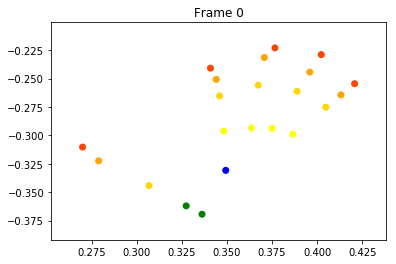

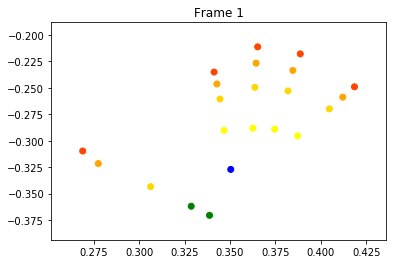

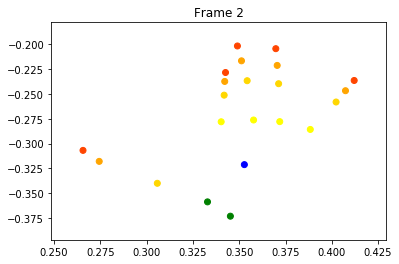

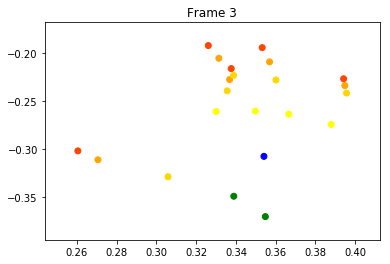

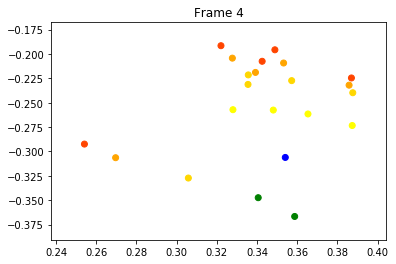

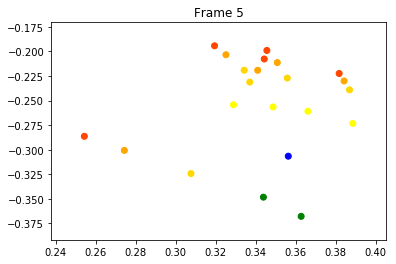

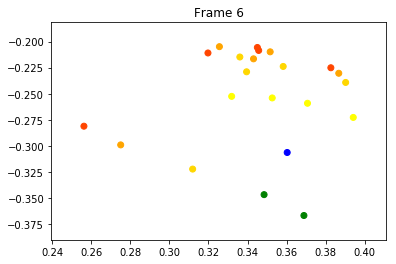

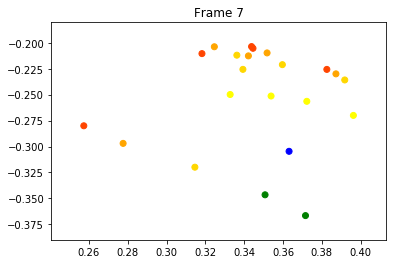

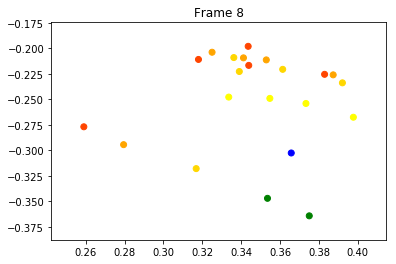

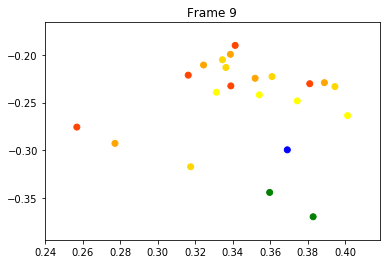

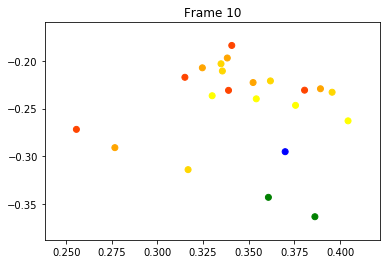

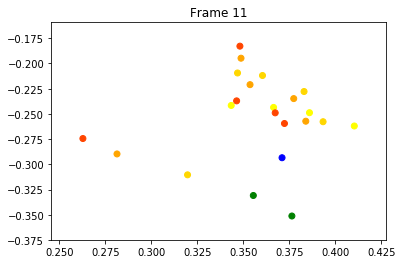

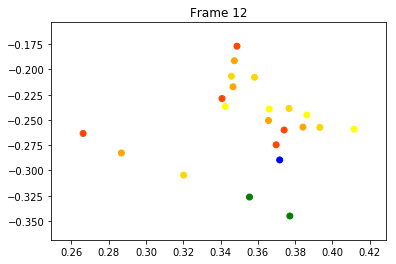

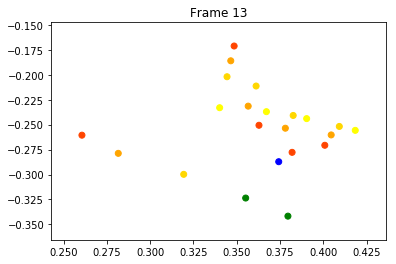

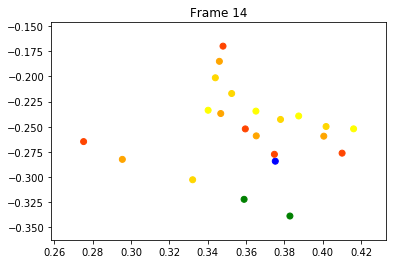

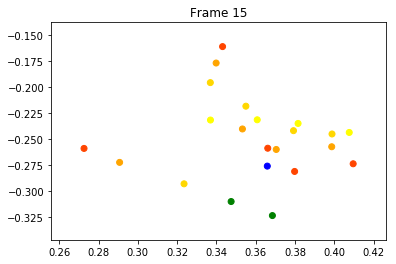

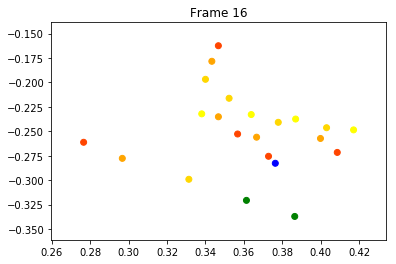

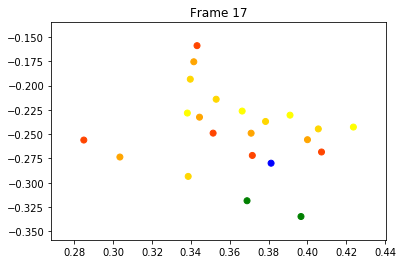

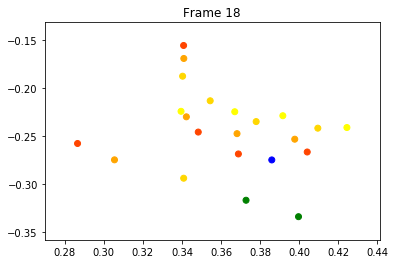

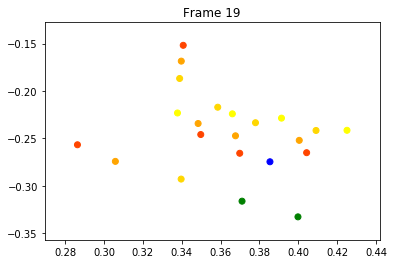

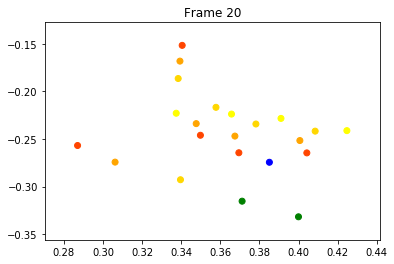

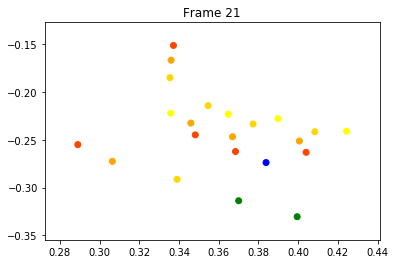

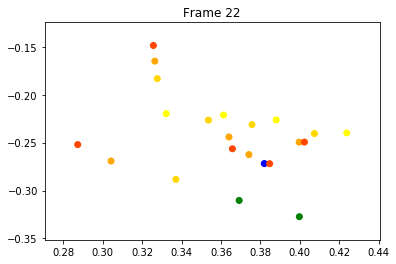

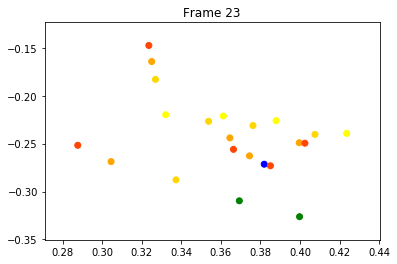

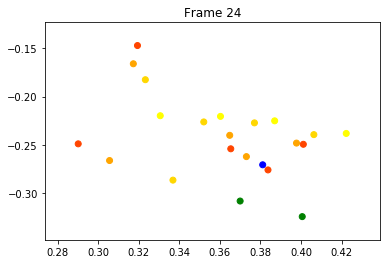

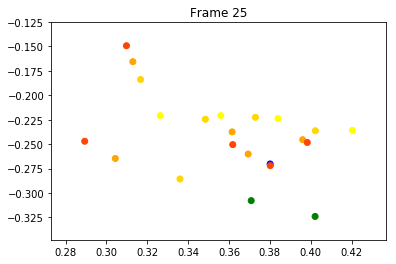

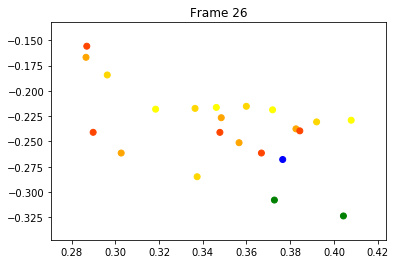

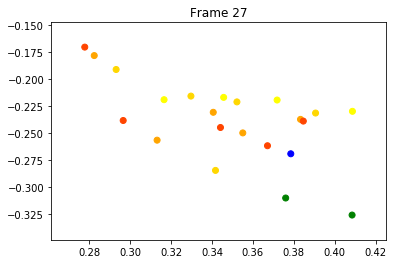

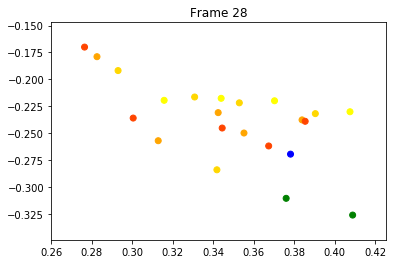

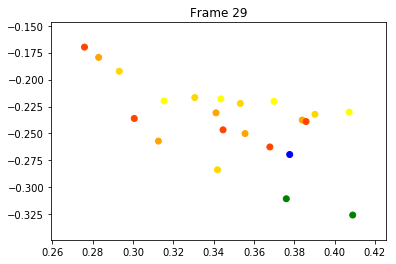

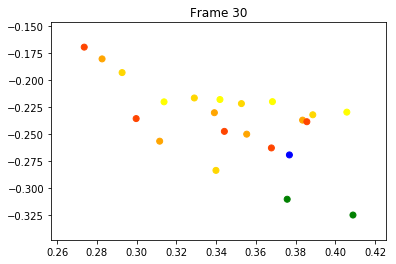

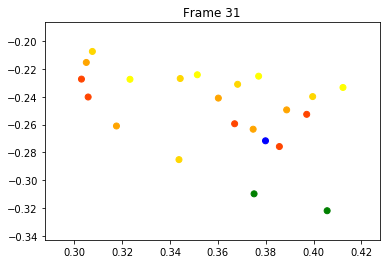

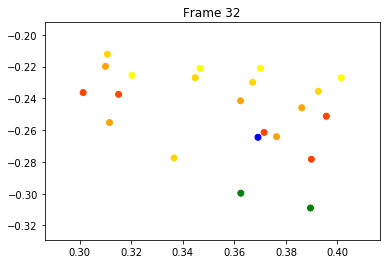

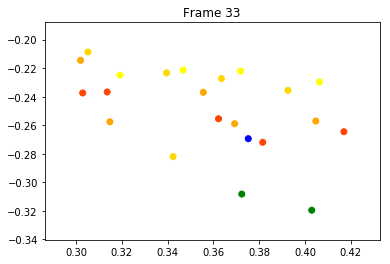

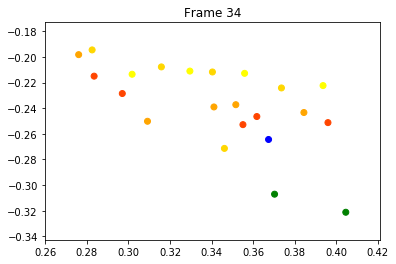

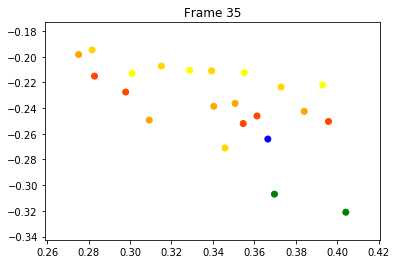

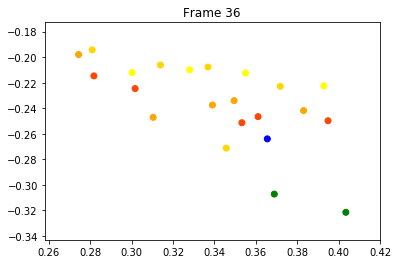

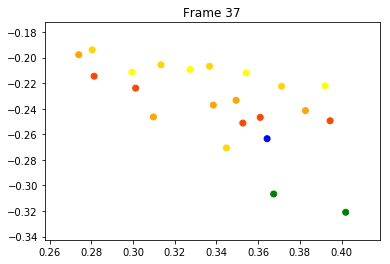

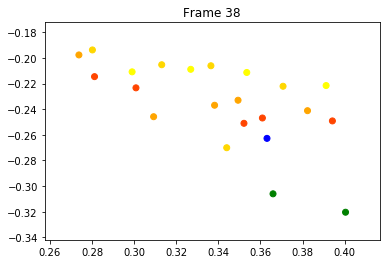

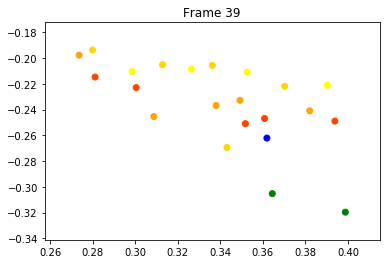

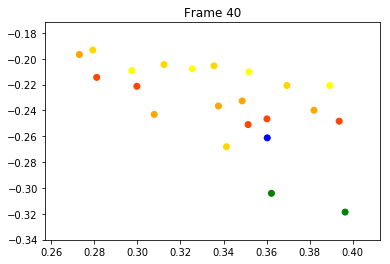

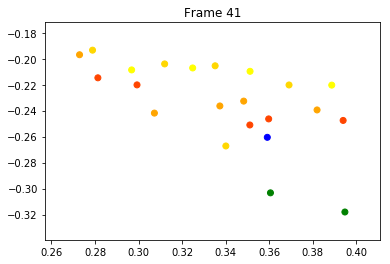

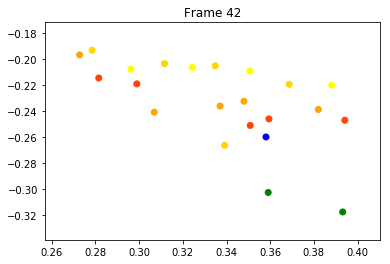

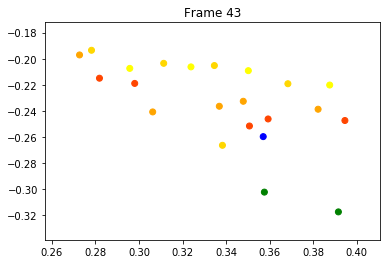

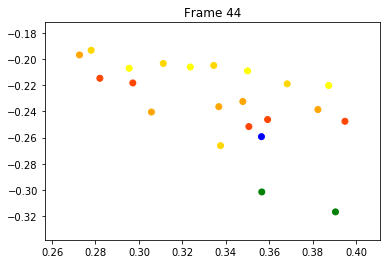

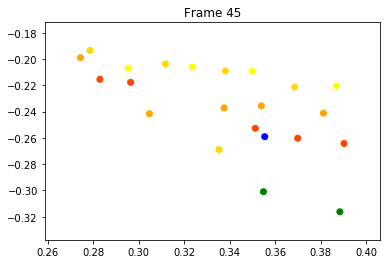

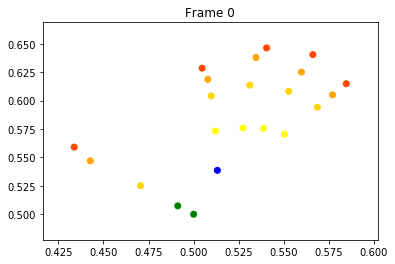

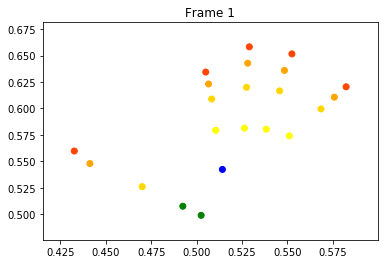

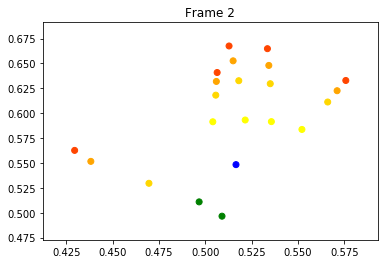

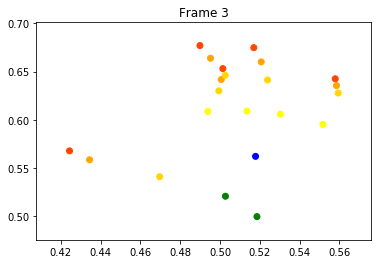

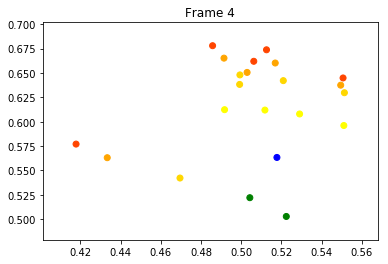

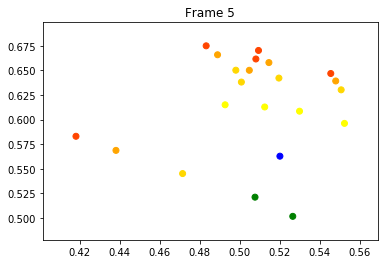

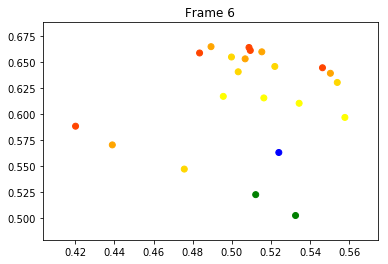

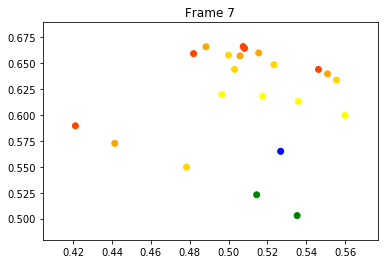

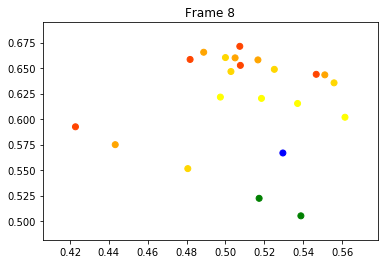

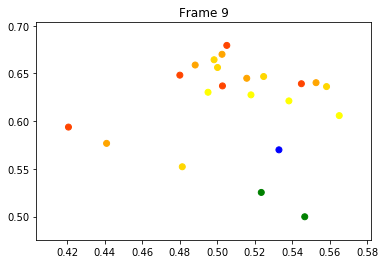

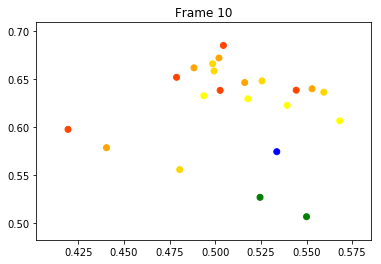

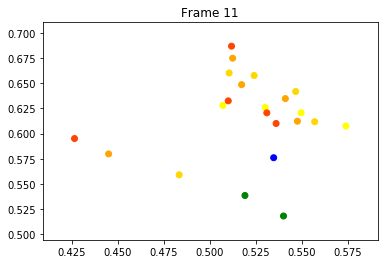

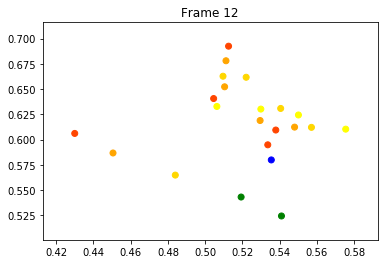

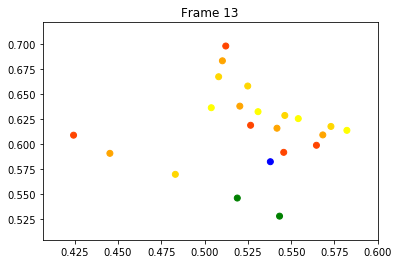

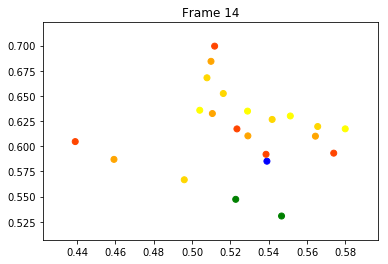

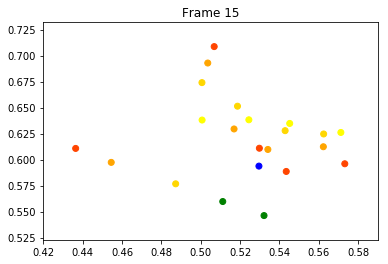

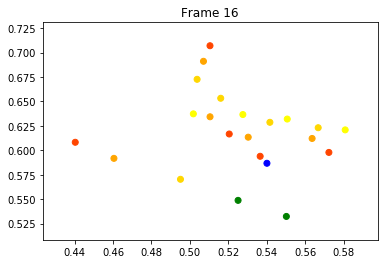

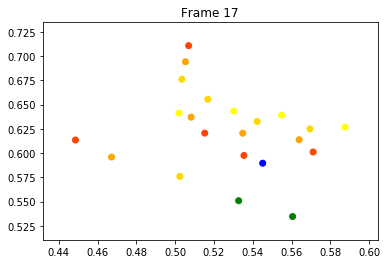

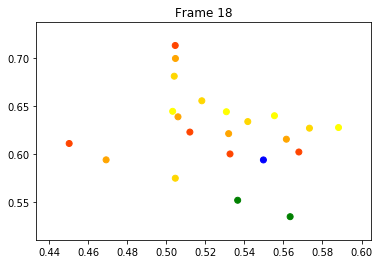

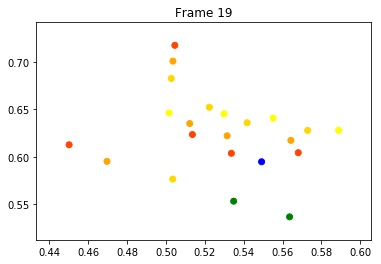

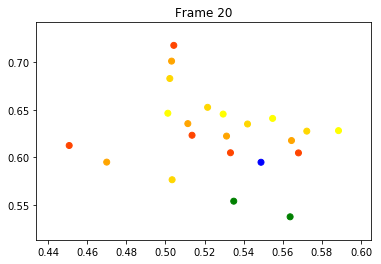

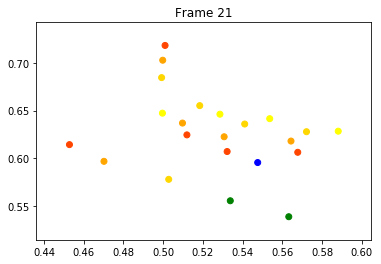

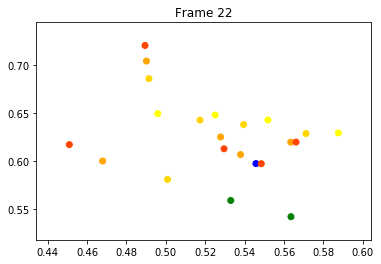

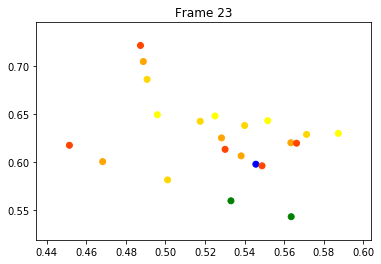

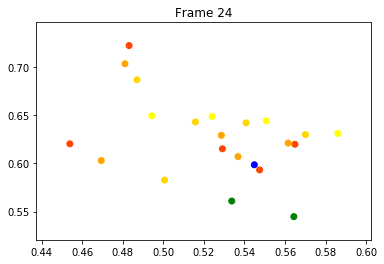

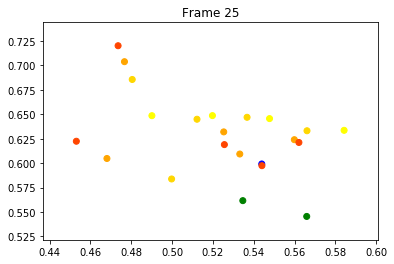

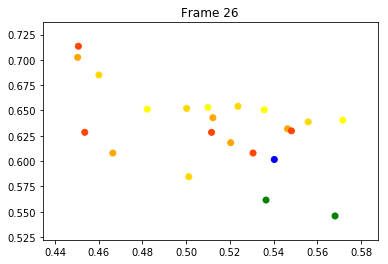

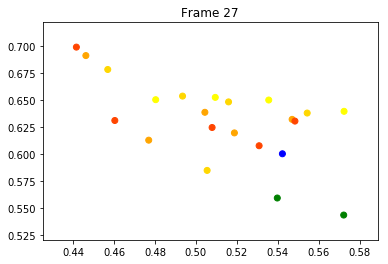

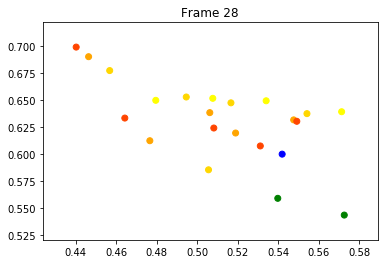

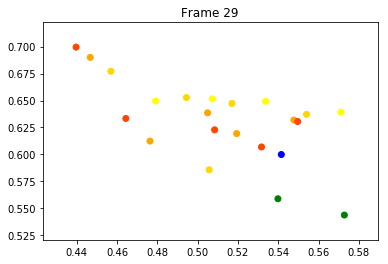

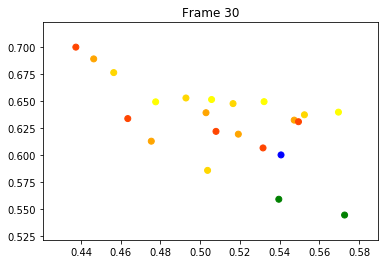

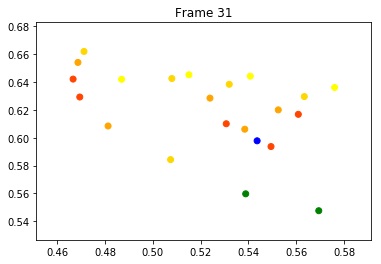

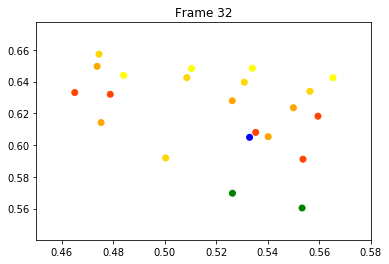

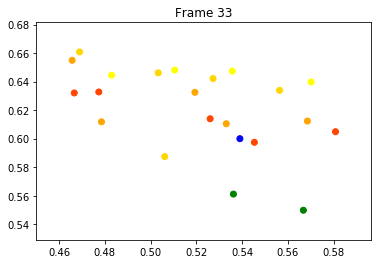

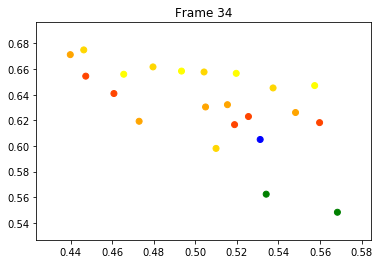

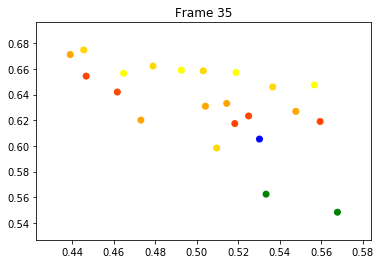

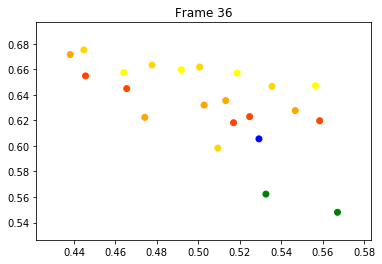

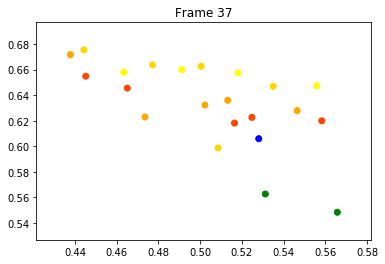

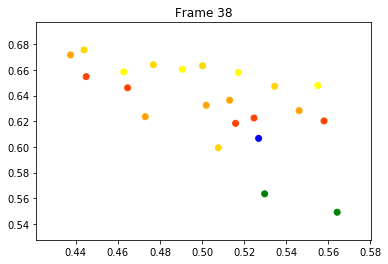

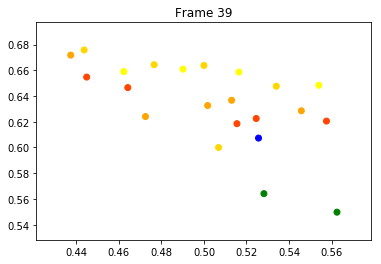

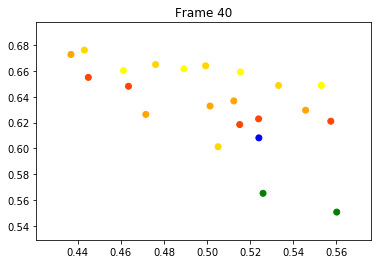

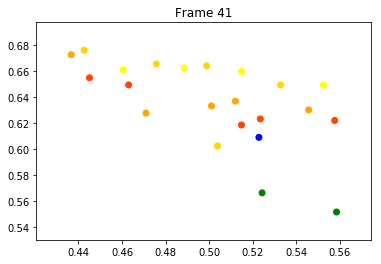

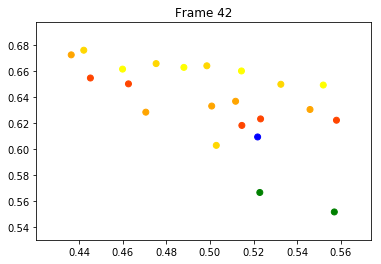

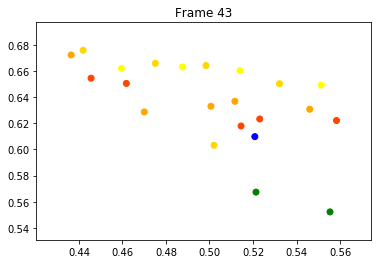

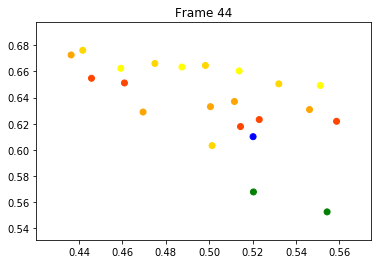

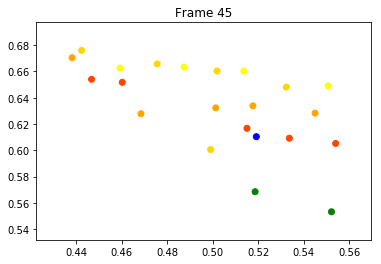

In [167]:
myPath = "/home/jovyan/data"
#myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'all', frames='all',trim=True) # Include all data points, all frames
#data = Data(myPath, features = 'fingertips', frames='first_middle_last') # fingertips only, using 3 frames at beginning middle, end of the gesture
#data = Data(myPath, features = 'wrist_palm', frames='middle_only') # wrist and palm points using only the middle frame

data.center()
data.display(0) # plot (in 2D the first gesture in the training set)
data.display(0,"modified") # plot (in 2D the first gesture in the training set)


Set up an SVM Kernel

In [29]:
import numpy as np
from numpy import linalg as LA
MAX_ITER = 5

def linear_kernel(x1, x2):
    return (1 + np.dot(x1, x2))
    
def polynomial_kernel(x1, x2, p = 3):
    return (1 + np.dot(x1, x2)) ** p
    
def gaussian_kernel(x1, x2, sigma = 0.5):
    return np.exp(-LA.norm(x1-x2)**2 / (2 * (sigma ** 2)))

In [229]:
class KernelPerceptron:
    def __init__(self, kernel = linear_kernel, Niter = 1):
        
        self.kernel = kernel
        self.Niter = Niter
        self.support_vector_x = None
        self.support_vector_y = None
        self.alpha = []
        self.bias = []
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples, dtype=np.float64)
        self.bias = np.zeros(n_samples, dtype=np.float64)

        for iter in range(self.Niter):
            for i in range(n_samples):
                sum = 0
                for j in range(n_samples): 
                    sum += self.alpha[j]*y[j]*(self.kernel(X[j],X[i]))
                if sum * y[i] <= 0:
                    self.alpha[i] += 1
                   
      # Support vectors
        sv = self.alpha > 1e-5 # ignore really small alphas - probably rounding issues
        self.alpha = self.alpha[sv]
        self.bias = self.bias[sv]
        self.support_vector_x = X[sv]
        self.support_vector_y = y[sv]
        print(np.count_nonzero(sv)," support vectors.")    
    
    def predict(self, X):
        n_samples = X.shape[0]
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            sum = 0
            for j in range(self.alpha.shape[0]):
                sum += self.alpha[j] * self.support_vector_y[j] * self.kernel(X[i], self.support_vector_x[j]+self.bias[j])
            y_predict[i] = sum
        return np.sign(y_predict)



In [264]:
myPath = "/home/jovyan/data"
#myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'all', frames='first_middle_last',trim=True) # Include all data points, all frames
mod_data = Data_Mods(data,"centered")
[X_train,y_train] = mod_data.concatenate('modified','by_frame')
print(data.y_train.shape)
print(y_train.shape," - ",y_train[0:5])
print(X_train.shape,X_train.shape[0])
mid_frame_X_train = X_train[:,0,:]
print(mid_frame_X_train.shape)
print(mid_frame_X_train[0:2,:])
print("*")
print(X_train[0:2,1,:])
print("**")
print(X_train[0])
d = 1
Niter = 20

# print("\nLinear Kernel")
# kp = KernelPerceptron(linear_kernel,Niter)
# kp.fit(data.X_train[0],data.y_train[0])
# y_hat = kp.predict(data.X_test)
# err = 0
# errs = []
# for i in range(len(data.y_test)):
#     if y_hat[i] != data.y_test[i]:
#         err += 1
#         errs.append(i)
# print("Errors: {0:4d} Accuracy: {1:4.2f}%".format(err,(1-err/len(data.y_test))*100))
# print("Misclassified: ",errs)

# print("\nPolynomial Kernel")
# kp = KernelPerceptron(polynomial_kernel,Niter)
# kp.fit(data.X_train,data.y_train)
# y_hat = kp.predict(data.X_test)
# err = 0
# errs = []
# for i in range(len(data.y_test)):
#     if y_hat[i] != data.y_test[i]:
#         err += 1
#         errs.append(i)
# print("Errors: {0:4d} Accuracy: {1:4.2f}%".format(err,(1-err/len(data.y_test))*100))
# print("Misclassified: ",errs)

# print("\nGaussian Kernel")
# kp = KernelPerceptron(gaussian_kernel,Niter)
# kp.fit(data.X_train,data.y_train)
# y_hat = kp.predict(data.X_test)
# err = 0
# errs = []
# for i in range(len(data.y_test)):
#     if y_hat[i] != data.y_test[i]:
#         err += 1
#         errs.append(i)
# print("Errors: {0:4d} Accuracy: {1:4.2f}%".format(err,(1-err/len(data.y_test))*100))
# print("Misclassified: ",errs)



Centering
(1400,)
(1400,)  -  [ 1.  1.  1.  1.  1.]
(1400, 3, 66) 1400
(1400, 66)
[[ 0.5         0.5         0.5         0.51315395  0.53863188  0.510351
   0.4912011   0.50736436  0.509992    0.47060789  0.52520733  0.519736
   0.4426853   0.54696652  0.514663    0.43377696  0.55911564  0.517879
   0.51207079  0.57318157  0.529566    0.50973244  0.60413954  0.536139
   0.50785647  0.61872958  0.539425    0.50466408  0.62856811  0.542412
   0.52739121  0.57591144  0.520639    0.53112762  0.61362853  0.524677
   0.53455091  0.63796647  0.527033    0.54041821  0.64638588  0.53386
   0.53881951  0.57559212  0.512526    0.55264269  0.60818742  0.519129
   0.55973263  0.62507627  0.522508    0.56609937  0.64047817  0.525579
   0.5503378   0.57041654  0.501424    0.56864926  0.59421904  0.498082
   0.57699717  0.60508191  0.496547    0.58459134  0.61488908  0.495192  ]
 [ 0.5         0.5         0.5         0.50713013  0.53716582  0.510042
   0.48477674  0.5052332   0.506153    0.45641405  0